<a href="https://colab.research.google.com/github/smlra-kjsce/DL-in-NLP-101/blob/master/LSTMs%20with%20Attention%20from%20Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM with Attention from Scratch

##Preprocessing
Credits: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

Understand torchtext further from: https://torchtext.readthedocs.io/en/latest/data.html

In [0]:
# to build the model
import torch
from torchtext import data
from torchtext import datasets
from torch import nn

# for repeatable results
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# specifically handle NLP data
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
TEXT.build_vocab

<bound method Field.build_vocab of <torchtext.data.field.Field object at 0x7faf03fd7c88>>

In [0]:
from torchtext import datasets

# getting the IMDB datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 8.64MB/s]


In [0]:
import random

# doing train-test split
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [0]:
MAX_VOCAB_SIZE = 25000

# building the vocabulary object with all properties
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 398564/400000 [00:16<00:00, 21887.05it/s]

In [0]:
# process used to build the data for training
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [0]:
train_data.examples[10].__dict__['text'] # viewing some examples of training data

['A',
 'DOUBLE',
 'LIFE',
 'has',
 'developed',
 'a',
 'mystique',
 'among',
 'film',
 'fans',
 'for',
 'two',
 'reasons',
 ':',
 'the',
 'plot',
 'idea',
 'of',
 'an',
 'actor',
 'getting',
 'so',
 'wrapped',
 'up',
 'into',
 'a',
 'role',
 '(',
 'here',
 'Othello',
 ')',
 'as',
 'to',
 'pick',
 'up',
 'the',
 'great',
 'flaw',
 'of',
 'that',
 'character',
 'and',
 'put',
 'it',
 'into',
 'his',
 'life',
 ';',
 'and',
 'that',
 'this',
 'is',
 'the',
 'film',
 'that',
 'won',
 'Ronald',
 'Colman',
 'the',
 'Academy',
 'Award',
 '(',
 'as',
 'well',
 'as',
 'the',
 'Golden',
 'Globe',
 ')',
 'as',
 'best',
 'actor',
 '.',
 'Let',
 "'s",
 'take',
 'the',
 'second',
 'point',
 'first.<br',
 '/><br',
 '/>Is',
 'Anthony',
 'John',
 'Colman',
 "'s",
 'greatest',
 'role',
 ',',
 'or',
 'even',
 'his',
 'signature',
 'role',
 '?',
 'I',
 'have',
 'my',
 'doubts',
 'on',
 'either',
 'level',
 '-',
 'but',
 'it',
 'is',
 'among',
 'his',
 'best',
 'known',
 'roles',
 '.',
 'Most',
 'of',
 'his

In [0]:
train_data.examples[10].__dict__['label'] # viewing some examples of labels

'pos'

##Playing with embeddings

In [0]:
TEXT.vocab.freqs # observing word frequencies

Counter({'Many': 224,
         'people': 6203,
         'see': 7803,
         'this': 42482,
         'as': 30410,
         'a': 109379,
         'classic': 1185,
         ',': 192728,
         'but': 24530,
         'I': 54484,
         'obviously': 707,
         'must': 2193,
         'have': 19884,
         'missed': 376,
         'something': 3384,
         '.': 165528,
         'Life': 211,
         'in': 61420,
         'Anarene': 3,
         'Texas': 148,
         'the': 203157,
         'early': 1059,
         '50': 274,
         "'s": 43493,
         'is': 76583,
         'pretty': 2444,
         'dull': 514,
         '-': 37178,
         'which': 8201,
         'means': 520,
         'that': 49478,
         'movie': 29809,
         'about': 11896,
         'life': 4362,
         'will': 6182,
         'be': 18766,
         'too': 5209,
         '!': 15350,
         'What': 1931,
         'it': 53833,
         'so': 12490,
         'many': 4465,
         '?': 10517,
         '

In [0]:
len(TEXT.vocab.freqs.keys()) # len of the vocabulary

101932

In [0]:
TEXT.vocab.stoi #mapping that saves which word corresponds to which index

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'<unk>': 0,
             '<pad>': 1,
             'the': 2,
             ',': 3,
             '.': 4,
             'and': 5,
             'a': 6,
             'of': 7,
             'to': 8,
             'is': 9,
             'in': 10,
             'I': 11,
             'it': 12,
             'that': 13,
             '"': 14,
             "'s": 15,
             'this': 16,
             '-': 17,
             '/><br': 18,
             'was': 19,
             'as': 20,
             'with': 21,
             'movie': 22,
             'for': 23,
             'film': 24,
             'The': 25,
             'but': 26,
             '(': 27,
             ')': 28,
             "n't": 29,
             'on': 30,
             'you': 31,
             'are': 32,
             'not': 33,
             'have': 34,
             'his': 35,
             'be': 36,
             'he': 37,
             'one': 38,
             '!': 39,
      

In [0]:
TEXT.vocab.itos # inverse mapping of which index contains which words

['<unk>',
 '<pad>',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'I',
 'it',
 'that',
 '"',
 "'s",
 'this',
 '-',
 '/><br',
 'was',
 'as',
 'with',
 'movie',
 'for',
 'film',
 'The',
 'but',
 '(',
 ')',
 "n't",
 'on',
 'you',
 'are',
 'not',
 'have',
 'his',
 'be',
 'he',
 'one',
 '!',
 'at',
 'by',
 'all',
 'an',
 'who',
 'they',
 'from',
 'like',
 'so',
 "'",
 'her',
 'or',
 'has',
 'about',
 'It',
 'just',
 'out',
 'do',
 '?',
 'some',
 'good',
 'more',
 'very',
 'would',
 'up',
 'what',
 'This',
 'there',
 'time',
 'can',
 'which',
 'when',
 'story',
 'really',
 'had',
 'if',
 'she',
 'only',
 'were',
 'see',
 'even',
 'their',
 'no',
 'my',
 'me',
 'did',
 'does',
 'than',
 '...',
 ':',
 'much',
 'been',
 'could',
 'get',
 'into',
 'people',
 'well',
 'will',
 'other',
 'bad',
 'because',
 'him',
 'we',
 'great',
 'made',
 'most',
 'first',
 'make',
 'how',
 'them',
 'also',
 'way',
 'its',
 '/>The',
 '<',
 'any',
 'too',
 'movies',
 'br',
 'character',
 'think',

In [0]:
TEXT.vocab.vectors # all word vectors being used

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.1640, -0.1446,  0.6948,  ..., -0.4320, -0.1155,  0.9253],
        [-0.9153,  0.4699, -0.6548,  ..., -0.2684, -0.3351, -0.2960],
        [ 0.3461, -0.0135, -0.1925,  ...,  0.5472, -0.2596,  0.3109]])

In [0]:
TEXT.vocab.vectors.shape # finding number of words and vector size used to encode the context

torch.Size([25002, 100])

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['king']] # vector for king

tensor([-0.3231, -0.8762,  0.2198,  0.2527,  0.2298,  0.7388, -0.3795, -0.3531,
        -0.8437, -1.1113, -0.3027,  0.3318, -0.2511,  0.3045, -0.0775, -0.8982,
         0.0925, -1.1407, -0.5832,  0.6687, -0.2312, -0.9585,  0.2826, -0.0788,
         0.7531,  0.2658,  0.3422, -0.3395,  0.9561,  0.0656,  0.4575,  0.3984,
         0.5796,  0.3927, -0.2185,  0.5879, -0.5600,  0.6337, -0.0440, -0.6873,
        -0.3784,  0.3803,  0.6164, -0.8827, -0.1235, -0.3793, -0.3832,  0.2387,
         0.6685, -0.4332, -0.1107,  0.0817,  1.1569,  0.7896, -0.2122, -2.3211,
        -0.6781,  0.4456,  0.6571,  0.1045,  0.4622,  0.1991,  0.2580,  0.0572,
         0.5344, -0.4313, -0.3431,  0.5979, -0.5842,  0.0690,  0.2394, -0.8518,
         0.3038, -0.3418, -0.2575, -0.0311, -0.1629,  0.4517, -0.9163,  0.6452,
         0.7328, -0.2275,  0.3023,  0.0448, -0.8374,  0.5501, -0.5251, -1.7357,
         0.4751, -0.7049,  0.0569, -0.7132,  0.0896,  0.4139, -1.3363, -0.6191,
        -0.3309, -0.5288,  0.1648, -0.98

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['king']].norm() # the magnitude of the vector

tensor(6.1176)

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['queen']] # queen vector

tensor([-0.5005, -0.7083,  0.5539,  0.6730,  0.2249,  0.6028, -0.2619,  0.7387,
        -0.6538, -0.2161, -0.3381,  0.2450, -0.5150,  0.8568, -0.3720, -0.5882,
         0.3064, -0.3067, -0.2187,  0.7837, -0.6194, -0.5493,  0.4307, -0.0273,
         0.9757,  0.4617,  0.1149, -0.9984,  1.0661, -0.2082,  0.5316,  0.4092,
         1.0406,  0.2494,  0.1871,  0.4153, -0.9541,  0.3682, -0.3795, -0.6802,
        -0.1458, -0.2011,  0.1711, -0.5570,  0.7191,  0.0700, -0.2364,  0.4953,
         1.1576, -0.0508,  0.2573, -0.0911,  1.2663,  1.1047, -0.5158, -2.0033,
        -0.6482,  0.1642,  0.3293,  0.0485,  0.1900,  0.6612,  0.0809,  0.3364,
         0.2276,  0.1462, -0.5100,  0.6378,  0.4730, -0.3282,  0.0839, -0.7855,
         0.0991,  0.0392,  0.2789,  0.1175,  0.5786,  0.0436, -0.1596, -0.3530,
        -0.0490, -0.3246,  1.4981,  0.5814, -1.1320, -0.6067, -0.3751, -1.1813,
         0.8012, -0.5001, -0.1657, -0.7058,  0.4301,  0.5105, -0.8033, -0.6657,
        -0.6372, -0.3603,  0.1335, -0.56

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['queen']].norm() # length of queen vector

tensor(6.0067)

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['man']] # vector for man

tensor([ 3.7293e-01,  3.8503e-01,  7.1086e-01, -6.5911e-01, -1.0128e-03,
         9.2715e-01,  2.7615e-01, -5.6203e-02, -2.4294e-01,  2.4632e-01,
        -1.8449e-01,  3.1398e-01,  4.8983e-01,  9.2560e-02,  3.2958e-01,
         1.5056e-01,  5.7317e-01, -1.8529e-01, -5.2277e-01,  4.6191e-01,
         9.2038e-01,  3.1001e-02, -1.6246e-01, -4.0567e-01,  7.8621e-01,
         5.7722e-01, -5.3501e-01, -6.8228e-01,  1.6987e-01,  3.6310e-01,
        -7.1773e-02,  4.7233e-01,  2.7806e-02, -1.4951e-01,  1.7543e-01,
        -3.7573e-01, -7.8517e-01,  5.8171e-01,  8.6859e-01,  3.1445e-02,
        -4.5897e-01, -4.0917e-02,  9.5897e-01, -1.6975e-01,  1.3045e-01,
         2.7434e-01, -6.9485e-02,  2.2402e-02,  2.4977e-01, -2.1536e-01,
        -3.2406e-01, -3.9867e-01,  6.8613e-01,  1.7923e+00, -3.7848e-01,
        -2.2477e+00, -7.7025e-01,  4.6582e-01,  1.2411e+00,  5.7756e-01,
         4.1151e-01,  8.4328e-01, -5.4259e-01, -1.6715e-01,  7.3927e-01,
        -9.3477e-02,  9.0278e-01,  5.0889e-01, -5.0

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['man']].norm() # len of vector for man

tensor(5.5936)

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['woman']]

tensor([ 0.5937,  0.4482,  0.5932,  0.0741,  0.1114,  1.2793,  0.1666,  0.2407,
         0.3905,  0.3277, -0.7503,  0.3501,  0.7606,  0.3807,  0.1752,  0.0318,
         0.4685, -0.2165, -0.4628,  0.3997,  0.1662, -0.0115,  0.0441,  0.3033,
         0.6153,  0.4705, -0.4404, -1.5963,  0.1843,  0.2319,  0.2045,  0.5162,
         0.6573, -0.3452,  0.2345, -0.6200, -0.6874,  0.2858,  1.0605,  0.4692,
        -0.8515,  0.1015,  0.2143, -0.2059,  0.2364,  0.2132, -0.2129,  0.1211,
         0.1877, -0.2328, -0.2550, -0.3963,  0.8438,  1.6801, -0.4094, -1.9976,
        -0.6987,  0.2173,  1.2197,  0.5513,  0.4410,  0.7259, -0.0921, -0.0224,
         0.7204,  0.1076,  0.8412,  0.3031, -0.4254,  0.0564,  0.1311, -0.0712,
        -0.1058,  0.5668,  0.5455,  0.8411,  0.1486, -0.6263, -0.6839, -1.0831,
        -0.0884,  0.3217,  0.4779,  0.0919, -1.2559, -1.2268,  0.0854,  0.3683,
         0.0816, -0.7661,  0.8775, -0.2201,  0.8240, -0.0922, -0.4594,  0.4657,
        -0.5602, -0.5465,  0.1516, -0.30

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['woman']].norm()

tensor(5.9617)

In [0]:
# KING - MAN + WOMAN ~ QUEEN 
(TEXT.vocab.vectors[TEXT.vocab.stoi['king']]-TEXT.vocab.vectors[TEXT.vocab.stoi['man']]+TEXT.vocab.vectors[TEXT.vocab.stoi['woman']]).dot(TEXT.vocab.vectors[TEXT.vocab.stoi['queen']])/((TEXT.vocab.vectors[TEXT.vocab.stoi['king']]-TEXT.vocab.vectors[TEXT.vocab.stoi['man']]+TEXT.vocab.vectors[TEXT.vocab.stoi['woman']]).norm()*(TEXT.vocab.vectors[TEXT.vocab.stoi['queen']]).norm())

tensor(0.7834)

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['king']]-TEXT.vocab.vectors[TEXT.vocab.stoi['man']]

tensor([-0.6960, -1.2612, -0.4911,  0.9118,  0.2308, -0.1884, -0.6557, -0.2969,
        -0.6007, -1.3576, -0.1182,  0.0178, -0.7410,  0.2119, -0.4071, -1.0487,
        -0.4807, -0.9554, -0.0605,  0.2068, -1.1516, -0.9896,  0.4451,  0.3268,
        -0.0331, -0.3114,  0.8772,  0.3428,  0.7862, -0.2975,  0.5292, -0.0740,
         0.5518,  0.5422, -0.3939,  0.9637,  0.2252,  0.0520, -0.9126, -0.7188,
         0.0806,  0.4212, -0.3426, -0.7129, -0.2539, -0.6536, -0.3137,  0.2163,
         0.4187, -0.2178,  0.2134,  0.4804,  0.4708, -1.0027,  0.1662, -0.0734,
         0.0922, -0.0202, -0.5840, -0.4731,  0.0507, -0.6442,  0.8006,  0.2243,
        -0.2048, -0.3379, -1.2459,  0.0890, -0.0839, -0.1955,  0.0850, -0.5575,
         0.1947, -0.0751, -0.6118, -0.0802, -0.3430,  1.0376, -0.3609,  0.9351,
        -0.0100, -0.5728,  0.3310,  0.2713,  0.4739,  1.1220, -0.0020, -1.6090,
         0.5738, -0.1702, -0.2291, -0.3382, -0.3678,  0.3680, -1.0896, -0.6648,
         0.0521,  0.4083,  0.1257, -0.44

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['earth']].dot(TEXT.vocab.vectors[TEXT.vocab.stoi['world']])/(TEXT.vocab.vectors[TEXT.vocab.stoi['earth']].norm()*TEXT.vocab.vectors[TEXT.vocab.stoi['world']].norm())

tensor(0.5213)

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['i']].dot(TEXT.vocab.vectors[TEXT.vocab.stoi['me']])/(TEXT.vocab.vectors[TEXT.vocab.stoi['i']].norm()*TEXT.vocab.vectors[TEXT.vocab.stoi['me']].norm())

tensor(0.8775)

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['life']].dot(TEXT.vocab.vectors[TEXT.vocab.stoi['death']])/(TEXT.vocab.vectors[TEXT.vocab.stoi['life']].norm()*TEXT.vocab.vectors[TEXT.vocab.stoi['death']].norm())

tensor(0.6755)

###Non-DL Approach, this also works!!!
But may not be the best you can get from data

In [0]:
s1 = "I like this movie"
s2 = "A boring movie"

In [0]:
A = TEXT.vocab.vectors[TEXT.vocab.stoi['love']]
B = TEXT.vocab.vectors[TEXT.vocab.stoi['hate']]

In [0]:
sum1 = torch.zeros_like(TEXT.vocab.vectors[TEXT.vocab.stoi['I']])
for i in s1.split(' '):
  sum1 += TEXT.vocab.vectors[TEXT.vocab.stoi[i]]*0.1/(0.1+TEXT.vocab.freqs[i]/25e3)

sum2 = torch.zeros_like(TEXT.vocab.vectors[TEXT.vocab.stoi['I']])
for i in s2.split(' '):
  sum2 += TEXT.vocab.vectors[TEXT.vocab.stoi[i]]*0.1/(0.1+TEXT.vocab.freqs[i]/25e3)

sum1 = sum1/len(s1)
sum2 = sum2/len(s2)

In [0]:
sum1

tensor([-0.0015,  0.0117,  0.0077, -0.0095, -0.0033,  0.0021, -0.0117, -0.0025,
        -0.0032,  0.0009, -0.0009, -0.0058,  0.0045,  0.0050,  0.0054,  0.0005,
         0.0054,  0.0063,  0.0038,  0.0149,  0.0077,  0.0051,  0.0020, -0.0057,
         0.0064,  0.0049, -0.0002, -0.0110, -0.0085,  0.0012,  0.0032,  0.0086,
        -0.0008, -0.0007,  0.0081,  0.0051,  0.0020,  0.0050, -0.0002, -0.0045,
        -0.0023,  0.0010, -0.0064, -0.0043,  0.0002, -0.0018,  0.0011, -0.0090,
        -0.0017, -0.0176, -0.0013, -0.0005,  0.0028,  0.0185, -0.0062, -0.0490,
        -0.0057,  0.0090,  0.0270,  0.0103, -0.0048,  0.0225, -0.0014,  0.0026,
         0.0116,  0.0018,  0.0162,  0.0029, -0.0013, -0.0030, -0.0012, -0.0111,
        -0.0022, -0.0051, -0.0096,  0.0049, -0.0024, -0.0016, -0.0030, -0.0008,
         0.0034, -0.0024, -0.0083,  0.0039, -0.0250, -0.0025, -0.0063, -0.0068,
        -0.0089, -0.0183,  0.0038, -0.0046, -0.0037, -0.0032, -0.0091, -0.0066,
        -0.0097, -0.0017,  0.0095,  0.00

In [0]:
print(sum1.dot(A)/(sum1.norm()*A.norm()))
print(sum2.dot(A)/(sum2.norm()*A.norm()))

tensor(0.7026)
tensor(0.3258)


In [0]:
print(sum1.dot(B)/(sum1.norm()*B.norm()))
print(sum2.dot(B)/(sum2.norm()*B.norm()))

tensor(0.5309)
tensor(0.3309)


In [0]:
sum2.norm()

tensor(0.3698)

#Making our LSTM  with attention
Important References: 
https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/deep_dives/lstm_from_scratch.ipynb
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/seq2seq_translation_tutorial.ipynb


##Importing all files and making the data available

In [0]:
%matplotlib inline

In [0]:
# for preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

# for building the model
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
!pip install torchviz
from torchviz import make_dot

# to use the GPU for free ;)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=3fafc35e581f6f78a3b9e6a5a7d0f9c2bed5d488a2386162244f6c348376f9e4
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
!wget https://download.pytorch.org/tutorial/data.zip # downloading the dataset

--2020-03-06 05:58:17--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.253.59, 13.224.253.114, 13.224.253.46, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.253.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2020-03-06 05:58:18 (29.1 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [0]:
!unzip -q "data.zip" # unzipping the dataset

##Preparing Data

In [0]:
SOS_token = 0 # used to indicate the start of the sentence and allow decoder to generate the translation
EOS_token = 1 # used to mark the end of generated sentence and stop decoder


class Lang:
    # a class to store all important text properties
    def __init__(self, name):
        self.name = name
        self.word2index = {} # word to index of vector of the word in the array of all vectors
        self.word2count = {} # stores count of every word
        self.index2word = {0: "SOS", 1: "EOS"} # stores which word is mapped to which index in the language
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        # creates above attributes for a sentence
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # checks and adds new words
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
# preprocessing all sentences
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 5

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    # selecting only those sentences which use above prefixes and are within given length
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
def prepareData(lang1, lang2, reverse=False):
    # preparing the entire dataset
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 1404 sentence pairs
Counting words...
Counted words:
fra 940
eng 466
['nous sommes reconnaissants .', 'we re grateful .']


##Model building

###Encoder

In [0]:
class LSTM_Encoder(nn.Module):
    def __init__(self, input_size, input_vector_size, hidden_size):
        super().__init__()
        self.input_size = input_size # Number of inputs
        self.input_vector_size = input_vector_size # size of embedding of input
        self.hidden_size = hidden_size # size of hidden state
        # input gate: sigmoid(w_ii*x+w_hi*h+b_i) has value in (0,1) which regulates how much effect input has on the cell state
        # self.W_ii = Parameter(torch.Tensor(input_sz, hidden_sz)) # weight used for input to generate new cell state
        # self.W_hi = Parameter(torch.Tensor(hidden_sz, hidden_sz)) # weight used for hidden state to generate new cell state
        # self.b_i = Parameter(torch.Tensor(hidden_sz)) # bias used to generate new cell state
        # can be simplified as:
        self.input_gate = nn.Linear(self.input_vector_size+hidden_size, hidden_size, bias = True)
        # forget gate: sigmoid(w_if*x+w_hf*h+b_f) has value in (0,1) which regulates how much cell state should be passed through the network
        # self.W_if = Parameter(torch.Tensor(input_sz, hidden_sz))
        # self.W_hf = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # self.b_f = Parameter(torch.Tensor(hidden_sz))
        self.forget_gate = nn.Linear(self.input_vector_size+hidden_size, hidden_size, bias = True)
        # generator: NOT a gate as it generate the value of the output with respect to the input and the hidden state and updates the cell state
        # self.W_ig = Parameter(torch.Tensor(input_sz, hidden_sz))
        # self.W_hg = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # self.b_g = Parameter(torch.Tensor(hidden_sz))
        self.generator = nn.Linear(self.input_vector_size+hidden_size, hidden_size, bias = True)
        # output gate: controls the amount of effect the new state can have on the hidden representations
        # self.W_io = Parameter(torch.Tensor(input_sz, hidden_sz))
        # self.W_ho = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # self.b_o = Parameter(torch.Tensor(hidden_sz))
        self.output_gate = nn.Linear(self.input_vector_size+hidden_size, hidden_size, bias = True)

        self.embedding = nn.Embedding(input_size, self.input_vector_size)
        
        #self.init_weights() # initializes all weights
    
    #def init_weights(self):
    #    for p in self.parameters():
    #        if p.data.ndimension() >= 2:
    #            nn.init.xavier_uniform_(p.data)
    #        else:
    #            nn.init.zeros_(p.data)

    def lstm(self, current_input, hidden_state, cell_state):
      # implementing forget gate
      self.after_forget_gate = torch.sigmoid(1+self.forget_gate(torch.cat([current_input, hidden_state],dim=2).reshape(-1,self.input_vector_size+self.hidden_size))) 
      # implementing input gate
      self.after_input_gate = torch.sigmoid(self.input_gate(torch.cat([current_input, hidden_state],dim=2).reshape(-1,self.input_vector_size+self.hidden_size)))
      # implementing output gate
      self.after_output_gate = torch.sigmoid(self.output_gate(torch.cat([current_input, hidden_state],dim=2).reshape(-1,self.input_vector_size+self.hidden_size)))
      # implementing the output generator
      self.after_generator = torch.tanh(self.generator(torch.cat([current_input, hidden_state],dim=2).reshape(-1,self.input_vector_size+self.hidden_size)))
      # forgetting cell_state
      self.cell_state_after_forgetting = cell_state*self.after_forget_gate
      # update to the cell_state
      self.new_partial_cell_state = self.after_input_gate * self.after_generator
      # final cell_state
      self.new_cell_state = self.cell_state_after_forgetting + self.new_partial_cell_state
      # generating new hidden state
      self.new_hidden_state = torch.tanh(self.new_cell_state)*self.after_output_gate
      return self.new_hidden_state, self.new_cell_state

    
    def forward(self, current_input, hidden_state, cell_state):
      self.current_input = current_input
      self.hidden_state = hidden_state
      self.cell_state = cell_state
      # converting words to vectors using indices
      self.embedded_current_input = self.embedding(self.current_input).view(1, 1, -1)
      # running the LSTM
    
      self.new_hidden_state, self.new_cell_state = self.lstm(self.embedded_current_input, self.hidden_state, self.cell_state)
      return self.new_hidden_state, self.new_hidden_state, self.new_cell_state
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###Decoder (With Attention)

In [0]:
class LSTM_Decoder(nn.Module):
    def __init__(self, input_vector_size, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.input_vector_size = input_vector_size # size of embedding of input
        self.hidden_size = hidden_size # size of hidden state
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = MAX_LENGTH

        # input gate: sigmoid(w_ii*x+w_hi*h+b_i) has value in (0,1) which regulates how much effect input has on the cell state
        # self.W_ii = Parameter(torch.Tensor(input_sz, hidden_sz)) # weight used for input to generate new cell state
        # self.W_hi = Parameter(torch.Tensor(hidden_sz, hidden_sz)) # weight used for hidden state to generate new cell state
        # self.b_i = Parameter(torch.Tensor(hidden_sz)) # bias used to generate new cell state
        # can be simplified as:
        self.input_gate = nn.Linear(2*hidden_size, hidden_size, bias = True)
        # forget gate: sigmoid(w_if*x+w_hf*h+b_f) has value in (0,1) which regulates how much cell state should be passed through the network
        # self.W_if = Parameter(torch.Tensor(input_sz, hidden_sz))
        # self.W_hf = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # self.b_f = Parameter(torch.Tensor(hidden_sz))
        self.forget_gate = nn.Linear(2*hidden_size, hidden_size, bias = True)
        # generator: NOT a gate as it generate the value of the output with respect to the input and the hidden state and updates the cell state
        # self.W_ig = Parameter(torch.Tensor(input_sz, hidden_sz))
        # self.W_hg = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # self.b_g = Parameter(torch.Tensor(hidden_sz))
        self.generator = nn.Linear(2*hidden_size, hidden_size, bias = True)
        # output gate: controls the amount of effect the new state can have on the hidden representations
        # self.W_io = Parameter(torch.Tensor(input_sz, hidden_sz))
        # self.W_ho = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        # self.b_o = Parameter(torch.Tensor(hidden_sz))
        self.output_gate = nn.Linear(2*hidden_size, hidden_size, bias = True)

        self.embedding = nn.Embedding(output_size, hidden_size) # embeddings for the input of decoder

        self.outcome = nn.Linear(hidden_size, output_size) # to compute the final output from the value returned from the LSTM

        self.attn = nn.Linear(2*self.hidden_size, self.max_length) # computing the attention over the entire input
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size) # combining the results after applying attention
        self.dropout = nn.Dropout(self.dropout_p) # for regularisation
        
        #self.init_weights() # initializes all weights
    
    #def init_weights(self):
    #    for p in self.parameters():
    #        if p.data.ndimension() >= 2:
    #            nn.init.xavier_uniform_(p.data)
    #        else:
    #            nn.init.zeros_(p.data)

    def lstm(self, current_input, hidden_state, cell_state):
      self.after_forget_gate = torch.sigmoid(1+self.forget_gate(torch.cat([current_input, hidden_state],dim=2).reshape(-1,2*self.hidden_size))) 
      self.after_input_gate = torch.sigmoid(self.input_gate(torch.cat([current_input, hidden_state],dim=2).reshape(-1,2*self.hidden_size)))
      self.after_output_gate = torch.sigmoid(self.output_gate(torch.cat([current_input, hidden_state],dim=2).reshape(-1,2*self.hidden_size)))
      self.after_generator = torch.tanh(self.generator(torch.cat([current_input, hidden_state],dim=2).reshape(-1,2*self.hidden_size)))
      self.cell_state_after_forgetting = cell_state*self.after_forget_gate
      self.new_partial_cell_state = self.after_input_gate * self.after_generator
      self.new_cell_state = self.cell_state_after_forgetting + self.new_partial_cell_state
      self.new_hidden_state = torch.tanh(self.new_cell_state)*self.after_output_gate
      return self.new_hidden_state, self.new_cell_state

    
    def forward(self, current_input, hidden_state, cell_state, encoder_outputs):
      self.current_input = current_input
      self.hidden_state = hidden_state
      self.cell_state = cell_state
      self.encoder_outputs = encoder_outputs # taking all outputs of the encoder to apply attention
      self.embedded_current_input = self.embedding(self.current_input).view(1, 1, -1) # index to vector for current input
      self.embedded_current_input = self.dropout(self.embedded_current_input) # regularisation

      # computing attention weights for all encoder outputs
      self.attn_weights = F.softmax(self.attn(torch.cat((self.embedded_current_input[0], self.hidden_state[0]), 1)), dim=1)
      self.attn_applied = torch.bmm(self.attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

      # combining current input and attention input
      self.new_input = torch.cat((self.embedded_current_input[0], self.attn_applied[0]), 1)
      self.new_input = self.attn_combine(self.new_input).unsqueeze(0)

      self.after_relu_on_input = F.relu(self.new_input)
      self.new_hidden_state, self.new_cell_state = self.lstm(self.after_relu_on_input, self.hidden_state, self.cell_state)
      self.output = F.log_softmax(self.outcome(self.new_hidden_state[0]))
      return self.output[0], self.new_hidden_state, self.new_cell_state, self.attn_weights

##Training the Model

In [0]:
def indexesFromSentence(lang, sentence):
    # converting words to indices
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    # converting index array to pytorch tensor
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    # making input and output tensors
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # initializing the hidden states to 0s for the encoder
    encoder_hidden = encoder.initHidden()
    cell_hidden = encoder.initHidden()

    # zeroing the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # finding the lengths to run in loop
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # zeroing the hidden state initially
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # running the encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell_state = encoder(
            input_tensor[ei], encoder_hidden, cell_hidden)
        encoder_hiddens[ei] = encoder_hidden[0, 0]

    # starting decoder with the SOS vector
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # initialising hidden and cell_state of decoder with that of the encoder
    decoder_hidden = encoder_hidden
    decoder_cell_state = encoder_cell_state

    # randomly passing its own output or actual output as input with some probability
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # running the decoder with target
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell_state, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell_state, encoder_hiddens)

            # using sum to accumulate all the loss
            loss += criterion(decoder_output.unsqueeze(0), target_tensor[di])

            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell_state, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell_state, encoder_hiddens)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output.unsqueeze(0), target_tensor[di])
            
            # stopping on end of sentence token
            if decoder_input.item() == EOS_token:
                break

    loss.backward() # computing gradients

    # updating weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    # returning average loss
    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    # time in minutes
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    # for computing the execution time
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    # to run the training loop
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # running the training loop

        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
# plotting progress of the model
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
encoder_gates = []
decoder_gates = []
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    global encoder_gates
    global decoder_gates
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        cell_state = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, cell_state = encoder(input_tensor[ei],
                                                     encoder_hidden, cell_state)
            encoder_outputs[ei] += encoder_output[0, 0]
            encoder_gates.append(encoder.after_forget_gate)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell_state = cell_state

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        # could have implemented beam search
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell_state, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell_state, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            decoder_gates.append(decoder.after_forget_gate)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    # seeing some examples
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 6s (- 160m 29s) (50 0%) 4.5529
0m 7s (- 92m 53s) (100 0%) 3.2129
0m 8s (- 70m 50s) (150 0%) 2.6558
0m 9s (- 60m 15s) (200 0%) 2.4048
0m 10s (- 53m 45s) (250 0%) 2.3267
0m 11s (- 49m 36s) (300 0%) 2.1548
0m 13s (- 46m 44s) (350 0%) 2.0382
0m 14s (- 44m 29s) (400 0%) 1.9869
0m 15s (- 43m 0s) (450 0%) 1.9673
0m 16s (- 41m 37s) (500 0%) 1.9824
0m 18s (- 40m 49s) (550 0%) 2.0219
0m 19s (- 39m 53s) (600 0%) 1.9455
0m 20s (- 38m 50s) (650 0%) 1.8861
0m 21s (- 38m 5s) (700 0%) 1.8914
0m 22s (- 37m 31s) (750 1%) 1.7974
0m 23s (- 36m 54s) (800 1%) 1.9449
0m 25s (- 36m 42s) (850 1%) 1.7782
0m 26s (- 36m 15s) (900 1%) 1.9037
0m 27s (- 35m 47s) (950 1%) 1.9139
0m 28s (- 35m 28s) (1000 1%) 1.9054
0m 29s (- 35m 10s) (1050 1%) 1.8733
0m 31s (- 34m 47s) (1100 1%) 1.7404
0m 32s (- 34m 40s) (1150 1%) 1.7568
0m 33s (- 34m 24s) (1200 1%) 1.7987
0m 34s (- 34m 5s) (1250 1%) 1.8570
0m 35s (- 33m 50s) (1300 1%) 1.8469
0m 37s (- 33m 39s) (1350 1%) 1.7765
0m 38s (- 33m 25s) (1400 1%) 1.7724
0m 39s (- 33m 13s)

<Figure size 432x288 with 0 Axes>

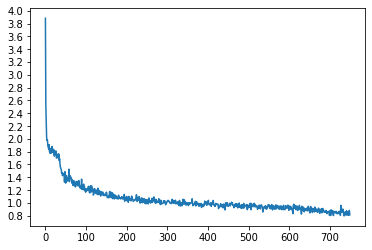

In [0]:
hidden_size = 256
input_vector_size = 100
encoder = LSTM_Encoder(input_lang.n_words,input_vector_size, hidden_size).to(device)
decoder = LSTM_Decoder(input_vector_size, hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, 75000, print_every=50, learning_rate=0.01)

In [0]:
evaluateRandomly(encoder, decoder)

> elle est obstinee .
= she is stubborn .
< she s innocent . <EOS>

> il est ivre .
= he is drunk .
< he s depressed . <EOS>

> me revoila .
= i m back .
< i m going . <EOS>

> il est sociable .
= he is outgoing .
< he is old . <EOS>

> elle est active .
= she is active .
< she s innocent . <EOS>

> vous etes creative .
= you re creative .
< you re nuts ! <EOS>

> elles sont parties .
= they re gone .
< they re mine . <EOS>

> tu es matinale .
= you re early .
< you re nuts ! <EOS>

> vous etes pathetiques .
= you re pathetic .
< you re nuts ! <EOS>

> tu es incroyable .
= you re amazing .
< you re nuts ! <EOS>



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


##Visualising the operations

In [0]:
evaluateRandomly(encoder, decoder)

> tu es grognon .
= you re grumpy .
< you re sick ! <EOS>

> je fredonne .
= i m humming .
< i m fine . <EOS>

> je suis laide .
= i m ugly .
< i m lazy . <EOS>

> je suis contagieux .
= i m contagious .
< i m lazy . .

> je rigole !
= i m kidding .
< i m going . <EOS>

> nous sommes serieux .
= we re serious .
< we re trapped ! <EOS>

> ils sont chretiens .
= they are christians .
< they re broke . <EOS>

> ils sont fous .
= they re crazy .
< they re rich . <EOS>

> vous etes creatives .
= you re creative .
< you re nuts ! <EOS>

> je suis impartiale .
= i m unbiased .
< i m lazy . .



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
a = encoder.current_input
b = encoder.hidden_state
c = encoder.cell_state

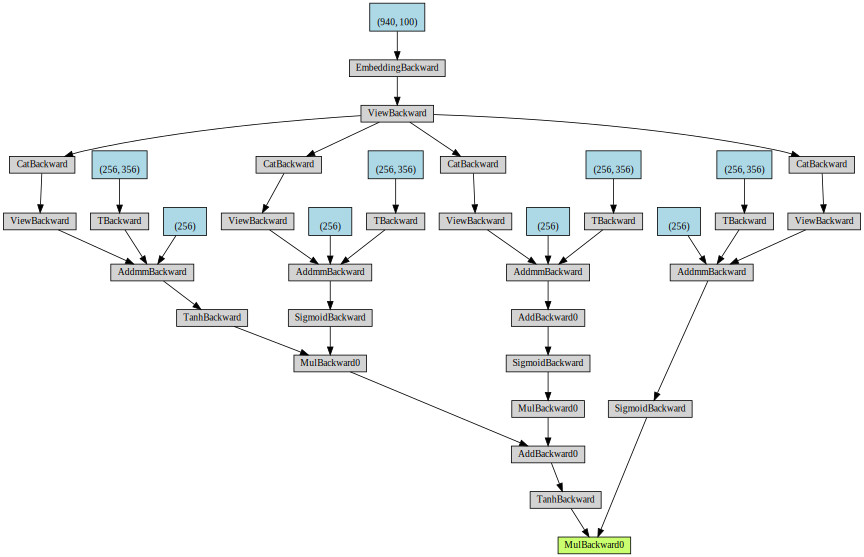

In [0]:
make_dot(encoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c))[0])

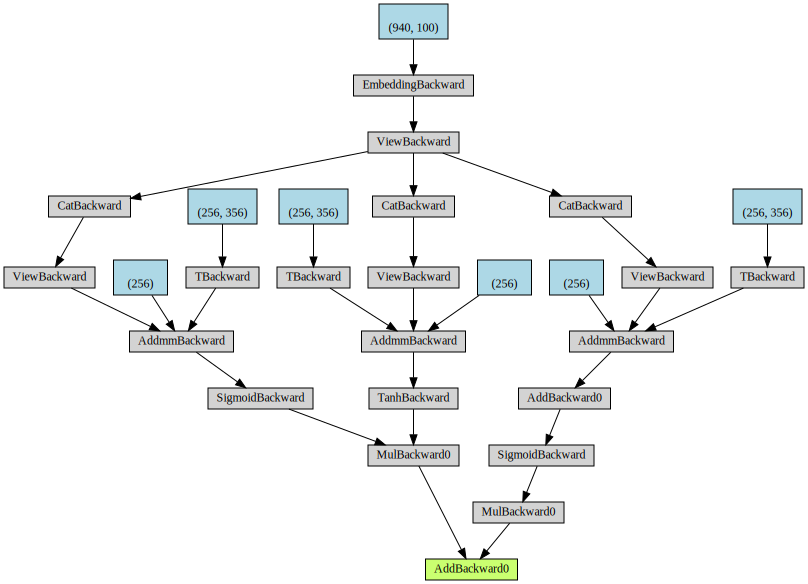

In [0]:
make_dot(encoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c))[2])

In [0]:
a = decoder.current_input
b = decoder.hidden_state
c = decoder.cell_state
d = decoder.encoder_outputs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


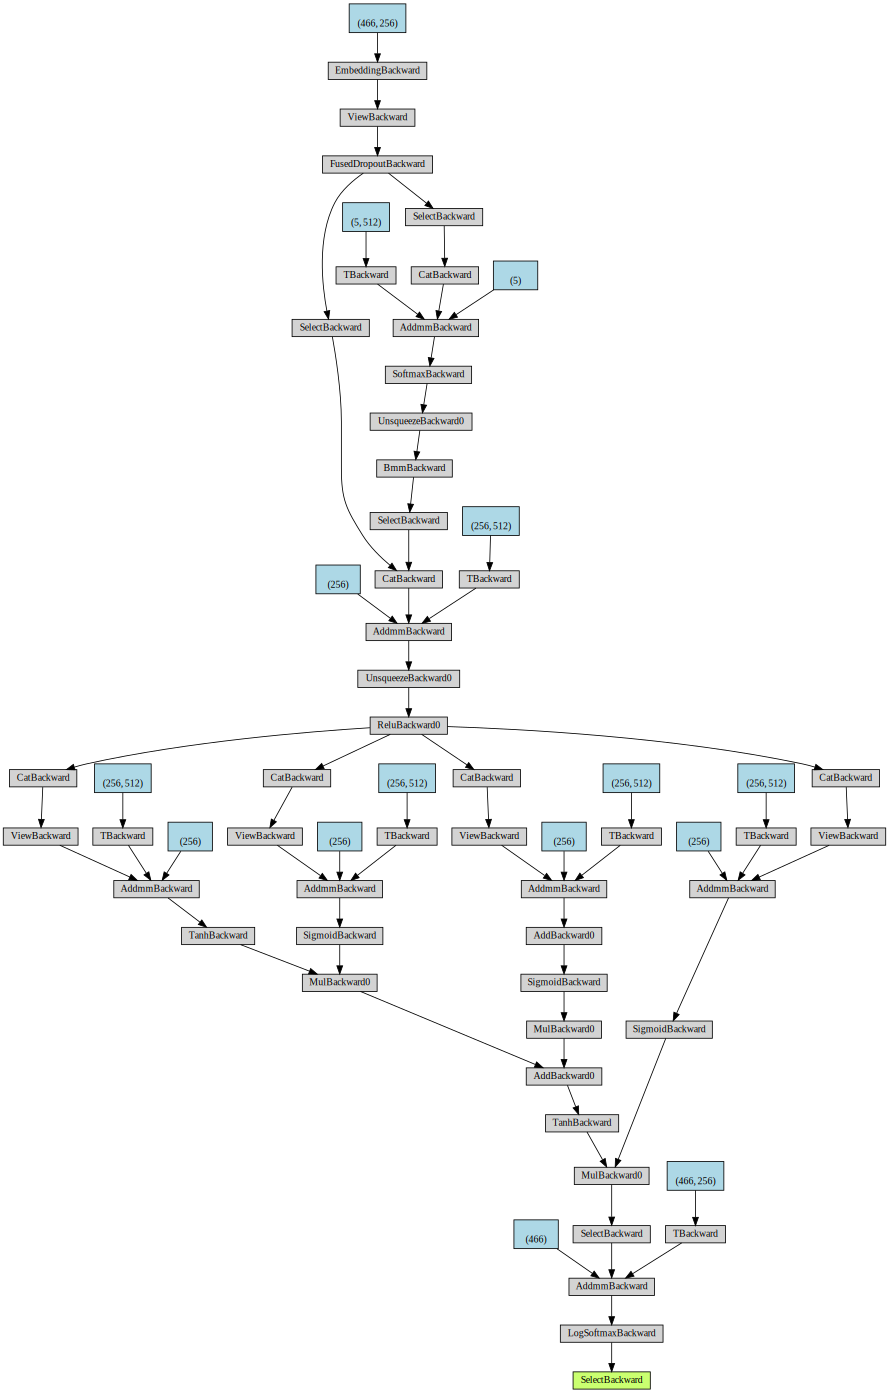

In [0]:
make_dot(decoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


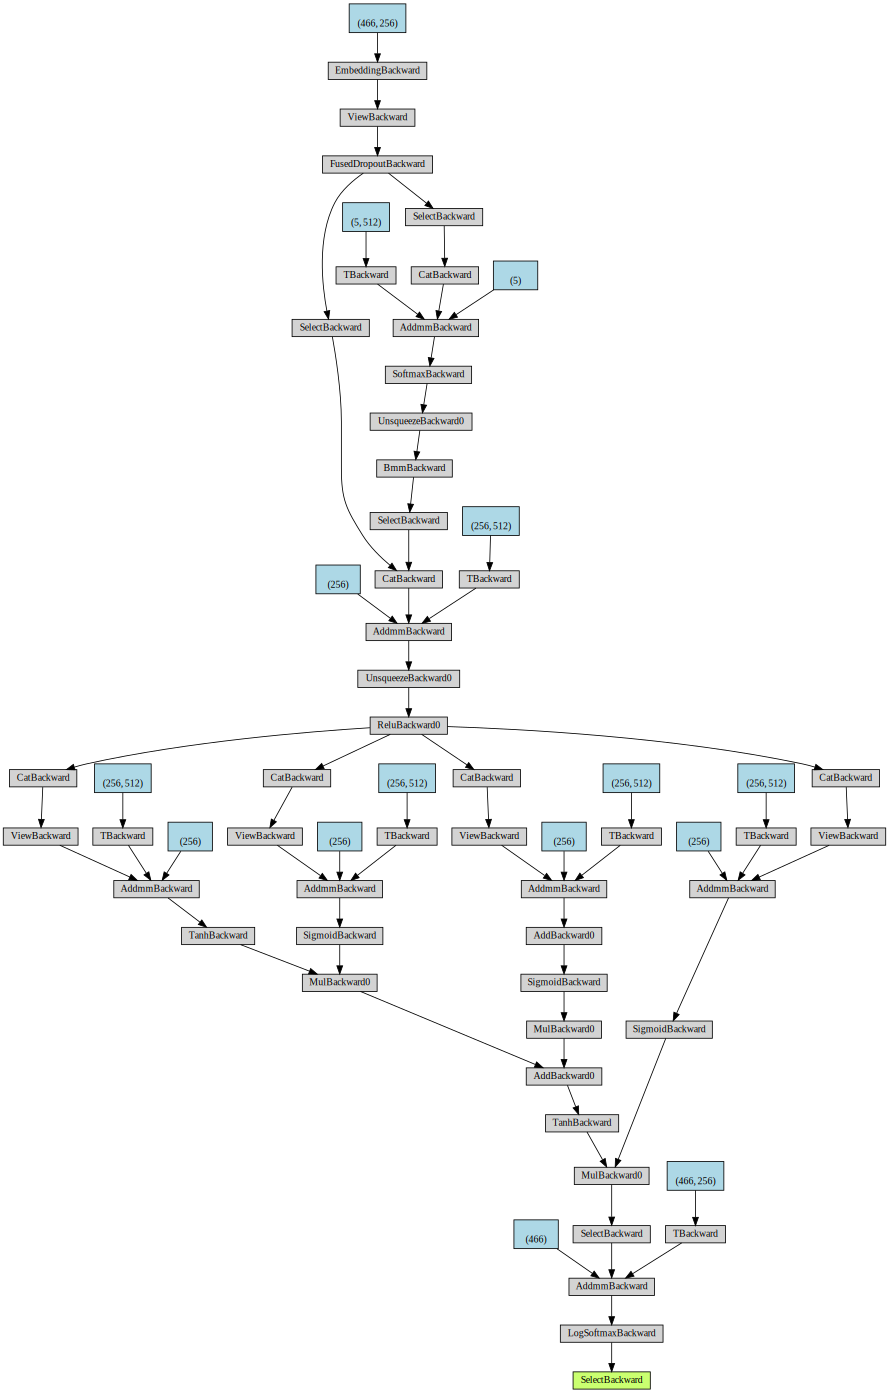

In [0]:
make_dot(decoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


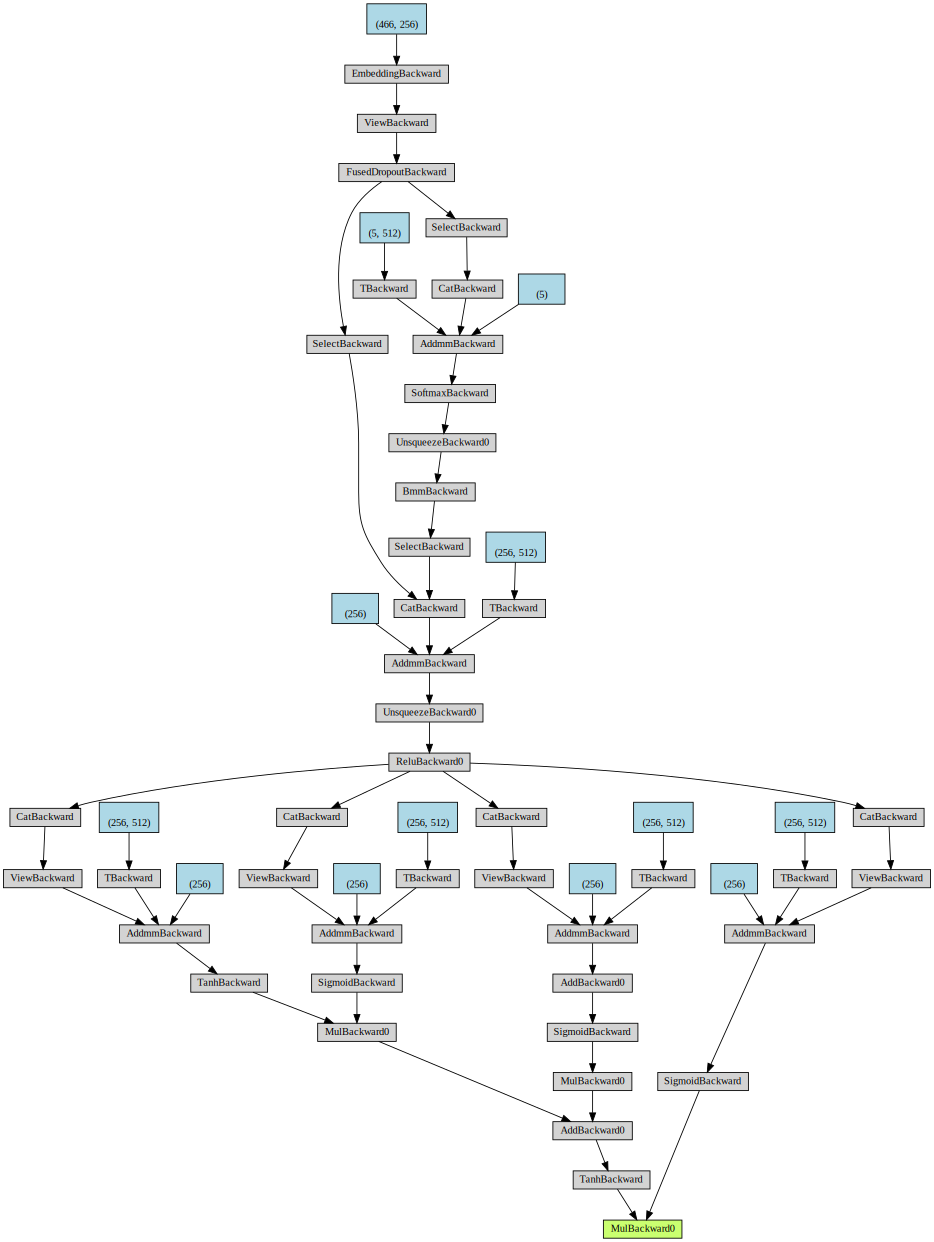

In [0]:
make_dot(decoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


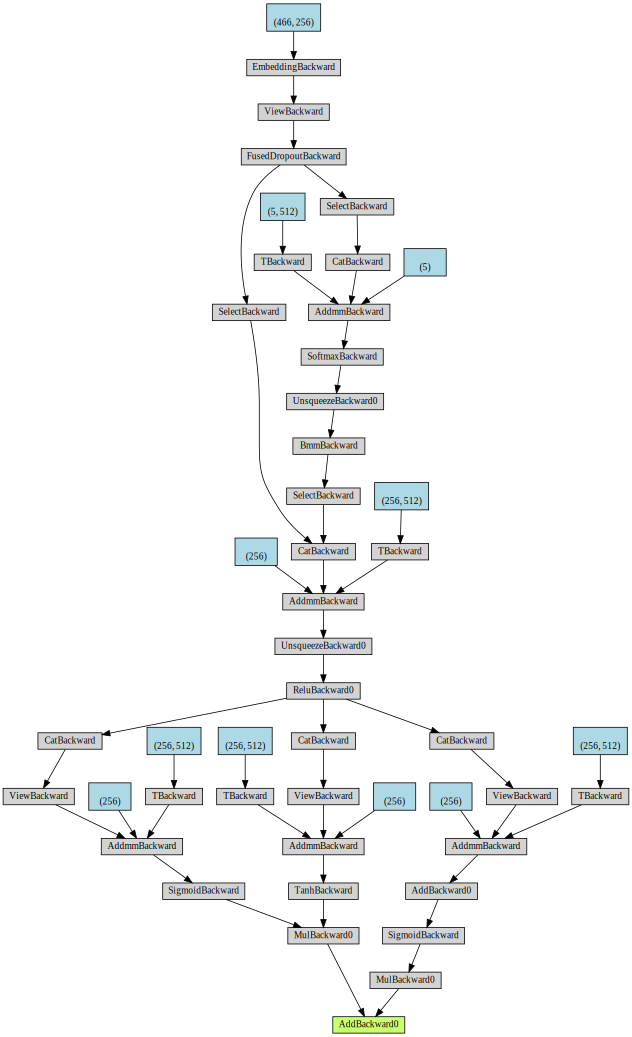

In [0]:
make_dot(decoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))[2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


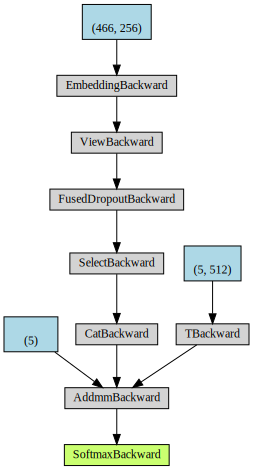

In [0]:
make_dot(decoder(torch.zeros_like(a),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))[3])

In [0]:
decoder.output.shape

torch.Size([1, 466])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


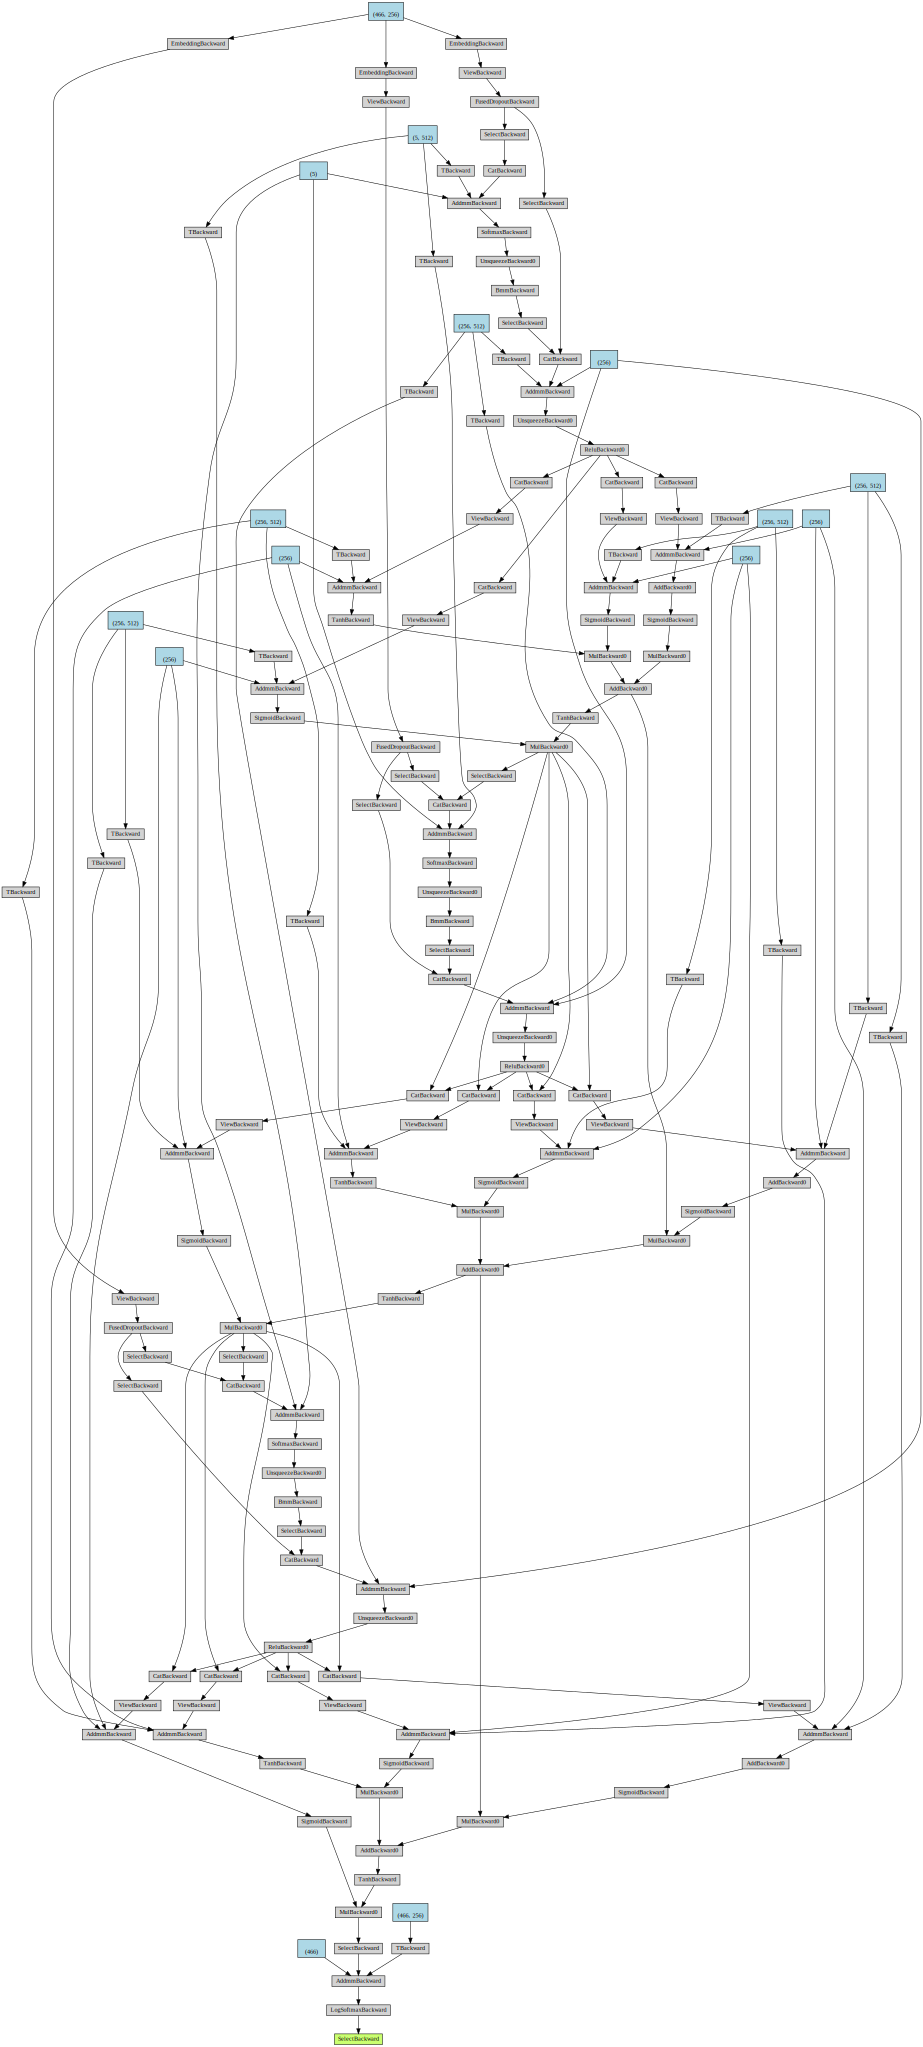

In [0]:
_,b,c,w = decoder(torch.zeros_like(a).long(),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))
_,b,c,w = decoder(torch.zeros_like(a).long(),b,c,torch.zeros_like(d))
_,b,c,w = decoder(torch.zeros_like(a).long(),b,c,torch.zeros_like(d))
make_dot(_)

In [0]:
opt = [0 for i in range(51)]
cs = [0 for i in range(51)]
hs = [0 for i in range(51)]
ws = [0 for i in range(51)]
opt[0],hs[0],cs[0],ws[0] = decoder(torch.zeros_like(a).long(),torch.zeros_like(b),torch.zeros_like(c),torch.zeros_like(d))
for i in range(50):
  opt[i+1],hs[i+1],cs[i+1],ws[i+1] = decoder(torch.zeros_like(a).long(),hs[i],cs[i],torch.zeros_like(d))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
for i in cs:
  i.retain_grad()

In [0]:
opt[-1].norm().backward()

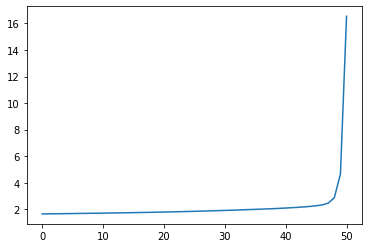

In [0]:
plt.plot(np.array([i for i in range(len(cs))]),np.array([cs[i].grad.norm().item() for i in range(len(cs))]))
plt.show()

In [0]:
[cs[i].grad.norm().item() for i in range(len(cs))]

[1.6450072526931763,
 1.6500247716903687,
 1.6549291610717773,
 1.6604300737380981,
 1.6662609577178955,
 1.6722910404205322,
 1.6793315410614014,
 1.684780478477478,
 1.6909757852554321,
 1.6962980031967163,
 1.7052969932556152,
 1.7125097513198853,
 1.7196513414382935,
 1.72688889503479,
 1.7344295978546143,
 1.7430819272994995,
 1.7503427267074585,
 1.758435845375061,
 1.767013669013977,
 1.7760167121887207,
 1.7854441404342651,
 1.7956916093826294,
 1.8069612979888916,
 1.8179941177368164,
 1.8287889957427979,
 1.8415956497192383,
 1.8534762859344482,
 1.8647514581680298,
 1.8797565698623657,
 1.8950802087783813,
 1.9083677530288696,
 1.921749472618103,
 1.9362943172454834,
 1.9555439949035645,
 1.9714365005493164,
 1.9892518520355225,
 2.0059878826141357,
 2.0228867530822754,
 2.0421199798583984,
 2.0648086071014404,
 2.0882580280303955,
 2.1139156818389893,
 2.1416592597961426,
 2.1732046604156494,
 2.210644245147705,
 2.259307861328125,
 2.3234293460845947,
 2.4582438468933105,


In [0]:
cs[-1].grad.norm()

tensor(16.5441, device='cuda:0')

In [0]:
encoder_gates = []
decoder_gates = []
ans, attention = evaluate(encoder, decoder,'je suis laide .')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


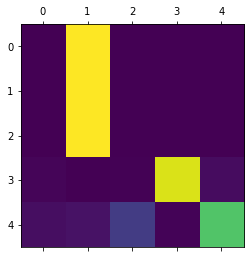

In [0]:
plt.matshow(attention)
plt.show()

In [0]:
ans

['i', 'm', 'lazy', '.', '<EOS>']

Actual: I am ugly.

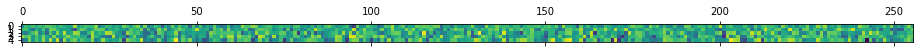

In [0]:
plt.matshow([i[0].cpu().numpy() for i in encoder_gates])

torch.Size([1, 256])


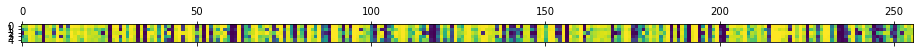

In [0]:
print(decoder_gates[0].shape)
plt.matshow([i[0].cpu().numpy() for i in decoder_gates])